In [14]:
import sys
import time
from typing import Tuple, List, Dict, Any, Callable

import gym

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from frozen_lake import MDP

In [15]:
# Create the environment
env = gym.make("FrozenLake-v1")
env.reset()
'''
The surface is described using a grid like the following:
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
'''
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Discrete(16)
Action space:  Discrete(4)


In [16]:
# Create an MDP from the env as a reference
mdp = MDP(env)

In [17]:
actions = {
    'Left': 0,
    'Down': 1,
    'Right': 2, 
    'Up': 3
}
 
act_seq = (2 * ['Right']) + (3 * ['Down'] + ['Right'])
print(f"Action sequence: {act_seq}")
 

env.render()
 
for a in act_seq:
    obs, rew, done, info = env.step(actions[a])
    env.render()
    print(f"Reward: {rew:.2f}")
    print(info, '\n')
    if done:
        break  

Action sequence: ['Right', 'Right', 'Down', 'Down', 'Down', 'Right']

SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333} 

  (Right)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333} 

  (Down)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333} 

  (Down)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333} 

  (Down)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333} 

  (Right)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333} 



## 1.1
Describe the environment state and action spaces, and reward function. Given a state
and an action, is the state transition deterministic?

State space: $S \in \{0,1,2,...,15\}$ represents the index from top-left to bottom-right of 4x4 grid. Each state $s$ can be $\{S,F,H,G\}$

where   
 
    S: starting point, safe
    F: frozen surface, safe
    H: hole, fall to your doom
    G: goal, where the frisbee is located

The terminal state is the goal state $G$ and hole state $H$.

Reward is 0 for every step taken in $\{S, F, H\}$, 1 for reaching the final goal state $G$.

$$ r = 1 \text{  if s = G}$$
$$ r = 0 \text{ Otherwise}$$

The state transition is not deterministic, becasue the transition probability of given state and action is not 1.

## 1.2
Starting with teh defintion of a value function, show that for a deterministic policy $\pi(s)$, the value function $v(s)$ can be expressed as:

$$v(s) = \sum_{s\prime \in S} p(s\prime|s,a) \big[r(s,a,s\prime) + \gamma v(s\prime)\big]$$

Return $G_t = \sum_{\tau=t}^{T} \gamma^{\tau-t} R_{\tau}$ 

Assume probabilistic transitions $T(s,a,s\prime) = R(s\prime|a,s)$

Deterministic policy $\pi(s) = a  \text{  }\forall a  \in A$

$$ v(s) = E_{\pi}\big[G_t|S_t=s\big]
\\ v(s) = E_{\pi}[\sum_{k=t}^{\infty} \gamma^{k-t}R_{k}|s_t=s] 
\\ = E_{\pi}[R_t + \gamma \sum_{k=t+1}^{\infty} \gamma^{k-t}R_{k}|s_t=s]
\\ = \sum_{a} \pi(a|s) \sum_{s\prime} p(s\prime|a,s) \big[r(s,a,s\prime)+ \gamma E_{\pi}[\sum_{k=t}^{\infty} \gamma^{k-t}R_{k}|s_{t+1}=s\prime]\big]
\\ = \sum_{a} \pi(a|s) \sum_{s\prime} p(s\prime|a,s) \big[r(s,a,s\prime)+ \gamma v(s\prime)\big]
$$

In our case, $a = \pi(s)$ is a deterministic policy, we can omit the probability of policy in the above equation.

$$v(s) = \sum_{s\prime \in S} p(s\prime|s,a) \big[r(s,a,s\prime) + \gamma v(s\prime)\big]$$



## 1.3
 Write  a  functionTestPolicy(policy),  that  returns  the  average  rate  of  successful episodes over 100 trials for a deterministic policy.  What is the success rate of a policy(number of times completed / total number of trials) given by $\pi(s) = (s+ 1)%4$.

In [18]:
def TestPolicy(
    self,
    policy: Callable,
    trials: int = 100,
    render: bool = False,
    verbose: bool = False,
) -> float:
    """
    Test a policy by running it in the given environment.

    :param policy: A policy to run.
    :param env: The environment to run the policy in.
    :param render: Whether to render the environment.

    :returns: success rate over # of trials.
    """
    assert trials > 0 and isinstance(trials, int)

    success = 0
    reward = 0
    for _ in range(trials):
        obs = self.env.reset()
        done = False
        while not done:
            act = policy(obs)
            obs, rew, done, info = self.env.step(act)
            reward += rew
            if render:
                self.env.render()
                time.sleep(0.1)
            if done and obs == 15:
                success += 1
    success_rate = success / trials
    mean_reward = reward / trials
    if verbose:
        print(f"Success rate: {success_rate}")
    return success_rate, mean_reward

In [19]:
# 3. Naive policy
policy = lambda s: (s + 1) % 4
naive_success_rates = []
for _ in range(10):
    naive_success_rate, _ = mdp.TestPolicy(policy, render=False)
    naive_success_rates.append(naive_success_rate)
print(f"Average naive_success_rates: {np.mean(naive_success_rates)}")

Average naive_success_rates: 0.013000000000000001


## 1.4
 Write a functionLearnModel,  that returns the transition probabilities $p(s'|a,s)$ andreward function $r(s,a,s')$.  Estimate these values over $10^5$ random samples.

In [20]:
    
def learnModel(self, n_samples: int = 10 ** 5) -> Tuple[np.ndarray, np.ndarray]:
    """
    Estimate transition probabilities p(s'|a, s) and
    reward function r(s, a, s') over n_samples random samples.

    :param n_samples: Number of random samples to use.
    :returns: transition probabilities and reward function.
    """
    assert n_samples > 0 and isinstance(n_samples, int)

    # Dimension of observation space and action space (both discrete)
    P = np.zeros((self.nS, self.nA, self.nS))  # transition probability: S x A x S' -> [0, 1]
    R = np.zeros_like(P)  # reward r(s, a, s')

    obs = self.env.reset()
    done = False
    for _ in range(n_samples):
        # Random action
        act = env.action_space.sample()
        nxt_obs, rew, done, _ = self.env.step(act)

        P[obs, act, nxt_obs] += 1
        R[obs, act, nxt_obs] += rew
        obs = nxt_obs

        if done:
            obs = self.env.reset()
    # Normalize transition probabilities -> [0,1]
    p1 = P.copy()  # Don't modify P dircetly
    for s in range(self.nS):
        for a in range(self.nA):
            total_counts = np.sum(P[s, a, :])
            if total_counts != 0:
                p1[s, a, :] /= total_counts
    # Avoid division by zero error
    R /= np.where(P!=0, P, 1)
    
    # Store the estimated transition probabilities and reward function 
    self.P_hat = p1
    self.R_hat = R
    return p1, R

In [21]:
p1, r1 = mdp.learnModel(n_samples=10 ** 5)
mse = lambda x, y: np.mean((x - y) ** 2)
    
MSE_P, MSE_R =  mse(mdp.P, p1), mse(mdp.R, r1)
print(f"Mean square error of P: {MSE_P}, \nMean square error of R: {MSE_R}")

Mean square error of P: 0.019590875126869862, 
Mean square error of R: 0.0013020833333333335


## 1.5
 Write a function PolicyEval() for evaluating a given deterministic policy and with the help of this function implement a policy iteration method to solve this environmentover 50 iterations. Plot the average rate of success of the learned policy at everyiteration.

In [22]:
def PolicyEval(
    self,
    V: np.ndarray,
    policy: np.ndarray,
    gamma: float,
    theta: float
):
    """
    Policy evaluation
    :param V: value function
    :param policy: a policy
    :param gamma: discount factor
    :param theta: tolerance or termination threshold
    """
    assert 0 < gamma < 1
    assert 0 < theta <= 1e-2, "Threshold should be a small positive number"  
    
    # Using the esitimations of the transition probabilities and reward function
    if self.P_hat is None or self.R_hat is None:
        self.learnModel()
    
    while True:
        delta = 0.0
        for s in range(self.nS):
            act = policy[s]
            Vs = 0
            for nxt_s in range(self.nS):
                Vs += self.P_hat[s, act, nxt_s] * (self.R_hat[s, act, nxt_s] + gamma * V[nxt_s])
            # Calculate delta
            delta = max(delta, abs(Vs - V[s]))
            # Update V
            V[s] = Vs       
        if delta < theta:
            break
    return V

In [23]:
def PolicyIteration(
    self,
    max_iter: int = 50,
    gamma: float = 0.99,
    theta: float = 1e-8
):
    """
    Policy iteration
    :param policy: a policy
    :param max_iter: maximum number of iterations
    :param gamma: discount factor
    :param theta: tolerance or termination threshold
    """
    assert max_iter > 0 and isinstance(max_iter, int)
    assert 0 < gamma < 1
    assert 0 < theta <= 1e-2, "Theta should be a small positive number"
    
    # Initialize V(s), \pi(s)
    V = np.zeros(self.nS)
    PI = np.zeros(self.nS, dtype=int)  # since actions are integers
    success_rates = []
    mean_rewards = []
    
    print(f'\n-------- Policy Iteration --------:')
    for i in range(max_iter):
        PI_old = PI.copy()
        print(f'Iteration {i+1}: ', end='')
        # Policy Evaluation
        V = self.PolicyEval(V, PI, gamma, theta)

        # Policy Improvement
        PI = self.PolicyImprovement(V, gamma)
        
        PI_fn = lambda s: PI[s]
        success_rate, mean_rew = self.TestPolicy(PI_fn, trials=100, render=False, verbose=True)
        success_rates.append(success_rate)
        mean_rewards.append(mean_rew)
        
        if np.all(PI_old == PI):
            print(f"\nPolicy is stable in {i} iterations")
            break
    
    return PI, V, success_rates, mean_rewards


-------- Policy Iteration --------:
Iteration 1: Success rate: 0.0
Iteration 2: Success rate: 0.0
Iteration 3: Success rate: 0.16
Iteration 4: Success rate: 0.29
Iteration 5: Success rate: 0.37
Iteration 6: Success rate: 0.7
Iteration 7: Success rate: 0.75
Iteration 8: Success rate: 0.79

Policy is stable in 7 iterations
PI: [0 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0]
V_pi: [0.52445732 0.47935172 0.45106133 0.43748746 0.54029043 0.
 0.35678146 0.         0.57243342 0.62462338 0.59945565 0.
 0.         0.73300084 0.86403638 0.        ]


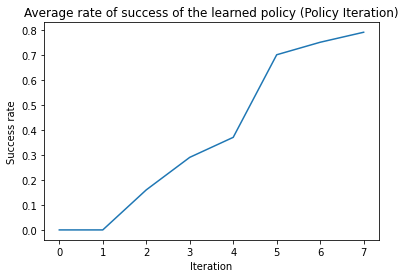

In [24]:
# 5. Policy iteration
PI, V_pi, success_rates, mean_rewards = mdp.PolicyIteration(50, theta=sys.float_info.epsilon)
print(f"PI: {PI}")
print(f"V_pi: {V_pi}")

plt.plot(success_rates)
plt.xlabel("Iteration")
plt.ylabel("Success rate")
plt.title("Average rate of success of the learned policy (Policy Iteration)")
plt.show()

## 1.6
 Write a function ValueIter() that returns a deterministic policy learned through value-iteration over 50 iterations. Plot the average rate of success of the learned policy atevery iteration.

In [25]:
def ValueIter(
    self,
    max_iter: int = 50,
    gamma: float = 0.99,
    theta: float = 1e-8
):
    assert max_iter > 0 and isinstance(max_iter, int)
    assert 0 < gamma < 1
    
    # Initialize V(s), \pi(s)
    V = np.zeros(self.nS)
    PI = np.zeros(self.nS, dtype=int)  # since actions are integers
    success_rates = []
    mean_rewards = []

    print(f'\n-------- Value Iteration --------:')
    for i in range(max_iter):
        print(f'Iteration {i+1}: ', end='')
        delta = 0.0
        for s in range(self.nS):
            v_old = V[s]
            # V(s) = max_a Q(s, a)
            Q = self.qValue(V, s, gamma)  # Q(s_t, a) -> Vector of Q-values 
            V[s] = max(Q)
            
            delta = max(delta, abs(V[s] - v_old))
        if delta < theta:
            break
        
        
        PI = self.PolicyImprovement(V, gamma)
        
        PI_fn = lambda s: PI[s]
        success_rate, mean_rew = self.TestPolicy(PI_fn, trials=100, render=False, verbose=True)
        success_rates.append(success_rate)
        mean_rewards.append(mean_rew)
    return PI, V, success_rates, mean_rewards


-------- Value Iteration --------:
Iteration 1: Success rate: 0.0
Iteration 2: Success rate: 0.0
Iteration 3: Success rate: 0.13
Iteration 4: Success rate: 0.13
Iteration 5: Success rate: 0.31
Iteration 6: Success rate: 0.39
Iteration 7: Success rate: 0.38
Iteration 8: Success rate: 0.46
Iteration 9: Success rate: 0.44
Iteration 10: Success rate: 0.48
Iteration 11: Success rate: 0.45
Iteration 12: Success rate: 0.43
Iteration 13: Success rate: 0.62
Iteration 14: Success rate: 0.72
Iteration 15: Success rate: 0.66
Iteration 16: Success rate: 0.69
Iteration 17: Success rate: 0.77
Iteration 18: Success rate: 0.74
Iteration 19: Success rate: 0.7
Iteration 20: Success rate: 0.74
Iteration 21: Success rate: 0.76
Iteration 22: Success rate: 0.75
Iteration 23: Success rate: 0.73
Iteration 24: Success rate: 0.73
Iteration 25: Success rate: 0.71
Iteration 26: Success rate: 0.78
Iteration 27: Success rate: 0.71
Iteration 28: Success rate: 0.76
Iteration 29: Success rate: 0.68
Iteration 30: Succe

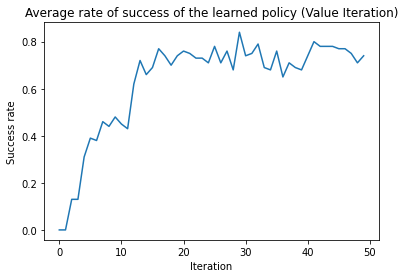

In [26]:
# 5. Value iteration
PI, V_pi, success_rates, mean_rewards = mdp.ValueIter(50, theta=sys.float_info.epsilon)
print(f"PI: {PI}")
print(f"V_pi: {V_pi}")

plt.plot(success_rates)
plt.xlabel("Iteration")
plt.ylabel("Success rate")
plt.title("Average rate of success of the learned policy (Value Iteration)")
plt.show()